In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import torch.nn as nn
import torch.nn.functional as F

In [2]:
## Training and Testing files
df_train = pd.read_csv('/mnt/suhas/OCR/nougat/config_s/CAMS/CAMS_newdata2/dataset_train.csv', encoding = "ISO-8859-1")
df_test = pd.read_csv('/mnt/suhas/OCR/nougat/config_s/CAMS/CAMS_newdata2/dataset_test.csv', encoding = "ISO-8859-1")
df_val = pd.read_csv('/mnt/suhas/OCR/nougat/config_s/CAMS/CAMS_newdata2/dataset_val.csv', encoding = "ISO-8859-1")


#training data
# df_train = pd.DataFrame(read_file, columns= ['selftext','ANNOTATIONS'])
df_train = df_train.rename(columns={'selftext': 'text','ANNOTATIONS':'label'})
df_train = df_train.convert_dtypes()

#testing data
# df_test = pd.DataFrame(read_file1,columns= ['selftext','ANNOTATIONS'])#### 
df_test = df_test.rename(columns={'selftext': 'text','ANNOTATIONS':'label'})
df_test = df_test.convert_dtypes()

#validation data
# df_val = pd.DataFrame(read_file2,columns= ['selftext','ANNOTATIONS'])####
df_val = df_val.rename(columns={'selftext': 'text','ANNOTATIONS':'label'})
df_val = df_val.convert_dtypes()

In [3]:
len(df_train), len(df_test), len(df_val)

(4076, 1486, 1384)

In [4]:


#training data
# df_train = pd.DataFrame(read_file, columns= ['selftext','ANNOTATIONS'])
df_train = df_train.rename(columns={'ï»¿text': 'text','category':'label'})
df_train = df_train.convert_dtypes()

#testing data
# df_test = pd.DataFrame(read_file1,columns= ['selftext','ANNOTATIONS'])#### 
df_test = df_test.rename(columns={'ï»¿text': 'text','category':'label'})
df_test = df_test.convert_dtypes()

#validation data
# df_val = pd.DataFrame(read_file2,columns= ['selftext','ANNOTATIONS'])####
df_val = df_val.rename(columns={'ï»¿text': 'text','category':'label'})
df_val = df_val.convert_dtypes()


In [6]:
df_test.columns

Index(['text', 'label', 'explanation'], dtype='object')

In [7]:
## some preprocessings due to wrong entries
df_test.drop(df_test[df_test.text=="emptypost"].index, inplace=True)
df_train.drop(df_train[df_train.text=="emptypost"].index, inplace=True)
df_test.drop(df_test[df_test.label==" "].index, inplace=True)
df_train.drop(df_train[df_train.label==" "].index, inplace=True)
df_test.dropna(inplace=True)
df_train.dropna(inplace=True)
df_val.dropna(inplace=True)

In [9]:
from transformers import AutoTokenizer, AutoModel
import sys
import csv
import re
import string
import pickle
from collections import defaultdict
from nltk.corpus import stopwords
from nltk import word_tokenize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from transformers import AdamW
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd

[nltk_data] Downloading package stopwords to /home/ai-interns-
[nltk_data]     jan22/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ai-interns-
[nltk_data]     jan22/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
stop_words = set(stopwords.words('english'))
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

In [11]:
def clean_text(text):
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text)     
    text = text.replace('x', '')
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    text = ' '.join(filtered_tokens)
    return text

In [12]:
df_train

,text,label,explanation
0,All I want is a moment of peace and silence. I...,4,"being bullied on a daily basis, humiliated, an..."
1,Like I am in so much pain but I canâÃÃ´t se...,5,"feeling so numb , i do not care"
2,"I mean, it's fucking awful man, I remember I u...",1,"I make people cry for no good reason, I feel f..."
3,"Growing up, people always tell me that I will ...",1,"im nothing , worthless and nobody , cried with..."
4,"Hello all, Using a throwaway account, but I ...",4,"can't trust my girlfriend, she ended pushing m..."
...,...,...,...
4069,Its my first year in college and everytime i ...,2,first year in college and everytime i go i f...
4070,I think I get misinterpreted a lot. I don't fe...,1,"get misinterpreted, need validation, don't fee..."
4072,Okay so this is extremely embarrassing and I h...,2,"called lazy, out of employment, bullied by co-..."
4073,"Neither in 2016. Also not in 2015. 2014, wha...",5,instead of working on my art and bounding with...


In [13]:
# training data
df_train = df_train.reset_index(drop=True)
df_train['text'] = df_train['text'].apply(clean_text)
df_train['text'] = df_train['text'].str.replace('\d+', '')


# val data
df_val = df_val.reset_index(drop=True)
df_val['text'] = df_val['text'].apply(clean_text)
# df_val['text'] = df_val['text'].str.replace('\d+', '')

# testing data
df_test = df_test.reset_index(drop=True)
df_test['text'] = df_test['text'].apply(clean_text)
df_test['text'] = df_test['text'].str.replace('\d+', '')

In [14]:
len(df_train), len(df_test), len(df_val)

(3535, 1259, 1215)

In [15]:
max([len(text.split()) for text in df_train['text']])

1569

In [16]:
train_text, train_labels = df_train['text'], df_train['label']
val_text, val_labels = df_val['text'], df_val['label']
test_text, test_labels = df_test['text'], df_test['label']

In [17]:
distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [18]:
# Global Variables

max_nb_words = 60000
max_features = 10543
maxlen = 350
emb_dim = 100
batch_size = 32
epochs  = 15


In [19]:
tokens_train = distilbert_tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = maxlen,
    pad_to_max_length = True,
    truncation = True,
    return_token_type_ids =False,
)

/mnt/suhas/packages/miniconda3/envs/parseq/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [20]:
tokens_val = distilbert_tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = maxlen,
    pad_to_max_length = True,
    truncation = True,
    return_token_type_ids =False,
)
tokens_test = distilbert_tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = maxlen,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [21]:
### Creating Tensors from the train, validation and test sequences ###
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

### Defining dataloaders

In [22]:
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
trainloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)


val_data = TensorDataset(val_seq, val_mask,val_y)
val_sampler = SequentialSampler(val_data)
valloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size,shuffle=False, drop_last=True)

In [23]:
test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
testloader = DataLoader(test_data, sampler = test_sampler, batch_size = batch_size,shuffle=False, drop_last=True)

In [24]:
len(trainloader), len(valloader), len(testloader)


(111, 37, 39)

In [31]:
from transformers import AutoTokenizer, BertModel, DistilBertModel

# DistilBERT-based model
class DistilBertModelClassifier(nn.Module):
    def __init__(self):
        super(DistilBertModelClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        # self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(768, 6)  # Output size 6

    def forward(self, sent_id, mask):
        distilbert_out = self.distilbert(sent_id, attention_mask=mask)
        pooled_out = distilbert_out.last_hidden_state[:, 0]  # CLS token representation
        # pooled_out = self.dropout(pooled_out)
        logits = self.fc(pooled_out)
        return logits


In [32]:
model = DistilBertModelClassifier()

In [33]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
import os
torch.cuda.empty_cache()
model = nn.DataParallel(model)
# os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
model.cuda()

DataParallel(
  (module): DistilBertModelClassifier(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ffn): FFN(
      

In [34]:
model

DataParallel(
  (module): DistilBertModelClassifier(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ffn): FFN(
      

## Model

In [35]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from transformers import TrainingArguments, Trainer
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

In [36]:
import pandas as pd
import pickle
#import torch
#import transformers
#from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import sys
import csv
import re
from tqdm.notebook import tqdm
import sys
import csv
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup


In [37]:
train_labels

0       4
1       5
2       1
3       1
4       4
       ..
3530    2
3531    1
3532    2
3533    5
3534    5
Name: label, Length: 3535, dtype: Int64

In [38]:
trainLabels = torch.tensor(train_labels)
class_count = torch.bincount(trainLabels)
class_weights = 1.0 / class_count
class_weights /= torch.sum(class_weights)

lossfn = nn.CrossEntropyLoss(weight=class_weights)
lossfn.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.015)

In [39]:
# Global Variables

max_nb_words = 60000
max_features = 10543
maxlen = 350
emb_dim = 100
batch_size = 32
epochs  = 10

# setup 2

In [40]:
model.to(device)


DataParallel(
  (module): DistilBertModelClassifier(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ffn): FFN(
      

In [41]:
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# Initialize metric tracking lists and best model tracking
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []
best_val_loss = float('inf')
best_model_state = None

# Move the model to the specified device once before the training loop
model.to(device)

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")
    
    # Training Phase
    model.train()
    epoch_train_loss = 0.0
    epoch_train_correct = 0
    epoch_train_total = 0

    progress_bar = tqdm(trainloader, desc="Training")
    for batch in progress_bar:
        inputs, mask, labels = batch
        inputs = inputs.squeeze().to(device)
        mask = mask.squeeze().to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, mask)
        loss = lossfn(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss and correct predictions
        epoch_train_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, dim=1)
        epoch_train_correct += (preds == labels).sum().item()
        epoch_train_total += labels.size(0)

        # Update progress bar
        batch_loss = loss.item()
        batch_acc = (preds == labels).float().mean().item()
        progress_bar.set_postfix({'loss': f"{batch_loss:.4f}", 'acc': f"{batch_acc:.4f}"})

    # Calculate average loss and accuracy for the epoch
    avg_train_loss = epoch_train_loss / epoch_train_total+1e-25
    train_accuracy = epoch_train_correct / epoch_train_total+1e-25
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(train_accuracy)
    
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation Phase
    model.eval()
    epoch_val_loss = 0.0
    best_val_acc = 0.0
    epoch_val_correct = 0
    epoch_val_total = 0

    with torch.no_grad():
        for batch in tqdm(valloader, desc="Validation", leave=False):
            inputs, mask, labels = batch
            # print(f"Batch inputs shape: {inputs.shape}")  # Expected: [batch_size, seq_length]
            # print(f"Batch mask shape: {mask.shape}")      # Expected: [batch_size, seq_length]
            # print(f"Batch labels shape: {labels.shape}")  # Expected: [batch_size]
            
            inputs = inputs.squeeze().to(device)
            mask = mask.squeeze().to(device)
            labels = labels.to(device)

            outputs = model(inputs, mask)
            loss = lossfn(outputs, labels)

            # Accumulate loss and correct predictions
            epoch_val_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, dim=1)
            epoch_val_correct += (preds == labels).sum().item()
            epoch_val_total += labels.size(0)

    # Calculate average loss and accuracy for validation
    avg_val_loss = epoch_val_loss / epoch_val_total
    val_accuracy = epoch_val_correct / epoch_val_total
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(val_accuracy)
    
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Check if the current model is the best so far and save it
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        torch.save(best_model_state, 'distilbert_best_model_loss.pth')
        print("Best model saved.")

    # Check if the current model is the best so far and save it wrt to accuracy
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        best_model_state = model.state_dict()
        torch.save(best_model_state, 'distilbert_best_model_acc.pth')
        print("Best model saved wrt accuracy.")

    #save the model
    torch.save(model.state_dict(), 'distilbert_model_final.pth')

    # Optional: Step the scheduler if you're using one
    # scheduler.step(avg_val_loss)


Epoch 1/10


Training: 100%|██████████| 111/111 [00:42<00:00,  2.58it/s, loss=1.4379, acc=0.4000]


Train Loss: 1.6419, Train Accuracy: 0.3214


Validation Loss: 1.4495, Validation Accuracy: 0.5321
Best model saved.
Best model saved wrt accuracy.
Epoch 2/10


Training: 100%|██████████| 111/111 [00:30<00:00,  3.66it/s, loss=1.7061, acc=0.5333]


Train Loss: 1.3060, Train Accuracy: 0.4767


Validation Loss: 1.2294, Validation Accuracy: 0.5439
Best model saved.
Best model saved wrt accuracy.
Epoch 3/10


Training: 100%|██████████| 111/111 [00:30<00:00,  3.64it/s, loss=1.4581, acc=0.4000]


Train Loss: 1.0419, Train Accuracy: 0.5601


Validation Loss: 1.1154, Validation Accuracy: 0.5642
Best model saved.
Best model saved wrt accuracy.
Epoch 4/10


Training: 100%|██████████| 111/111 [00:30<00:00,  3.67it/s, loss=0.8652, acc=0.6667]


Train Loss: 0.8067, Train Accuracy: 0.6543


Validation Loss: 1.1453, Validation Accuracy: 0.6867
Best model saved wrt accuracy.
Epoch 5/10


Training: 100%|██████████| 111/111 [00:30<00:00,  3.67it/s, loss=0.7591, acc=0.5333]


Train Loss: 0.5782, Train Accuracy: 0.7378


Validation Loss: 1.2080, Validation Accuracy: 0.6782
Best model saved wrt accuracy.
Epoch 6/10


Training: 100%|██████████| 111/111 [00:30<00:00,  3.67it/s, loss=0.4212, acc=0.7333]


Train Loss: 0.4157, Train Accuracy: 0.8076


Validation Loss: 1.1880, Validation Accuracy: 0.7213
Best model saved wrt accuracy.
Epoch 7/10


Training: 100%|██████████| 111/111 [00:30<00:00,  3.69it/s, loss=0.6123, acc=0.8667]


Train Loss: 0.2823, Train Accuracy: 0.8707


Validation Loss: 1.2757, Validation Accuracy: 0.7660
Best model saved wrt accuracy.
Epoch 8/10


Training: 100%|██████████| 111/111 [00:29<00:00,  3.70it/s, loss=0.1810, acc=0.8667]


Train Loss: 0.1876, Train Accuracy: 0.9171


Validation Loss: 1.2501, Validation Accuracy: 0.7466
Best model saved wrt accuracy.
Epoch 9/10


Training: 100%|██████████| 111/111 [00:30<00:00,  3.68it/s, loss=0.0706, acc=1.0000]


Train Loss: 0.1507, Train Accuracy: 0.9349


Validation Loss: 1.3957, Validation Accuracy: 0.7677
Best model saved wrt accuracy.
Epoch 10/10


Training: 100%|██████████| 111/111 [00:29<00:00,  3.70it/s, loss=0.0374, acc=1.0000]


Train Loss: 0.0868, Train Accuracy: 0.9661


Validation Loss: 1.3303, Validation Accuracy: 0.7762
Best model saved wrt accuracy.


In [42]:
epochs = list(range(1, epochs + 1))

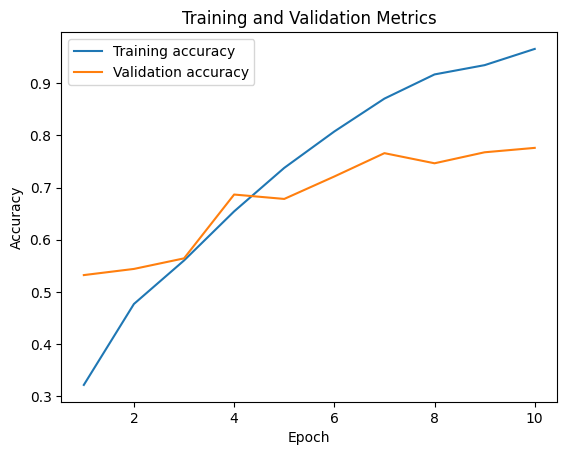

In [43]:
plt.plot(epochs, train_acc_list, label='Training accuracy')
plt.plot(epochs, val_acc_list, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Metrics')
plt.legend()
plt.show()

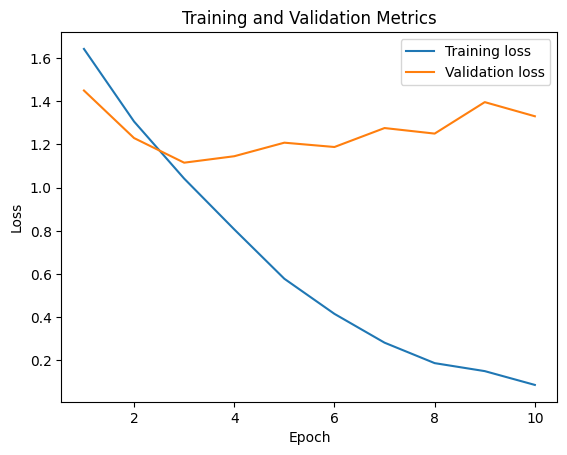

In [44]:
plt.plot(epochs, train_loss_list, label='Training loss')
plt.plot(epochs, val_loss_list, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Metrics')
plt.legend()
plt.show()

## Evaluation

In [45]:
def compute_metrics(preds, labels):
    labels = labels
    preds = preds
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [46]:
model.eval()

test_predictions = []
test_labels = []
with torch.no_grad():
  for batch in testloader:
    inputs, mask, labels = batch
    inputs = inputs.squeeze().to(device)
    mask = mask.squeeze().to(device)
    labels = labels.to(device)
    outputs = model(inputs, mask)
    outputs.to(device)
    loss = lossfn(outputs, labels)
    logits = outputs
    test_predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
    test_labels.extend(labels.cpu().numpy().tolist())

test_acc = accuracy_score(test_labels, test_predictions)
test_f1 = f1_score(test_labels, test_predictions, average='weighted')
print('Test accuracy:', test_acc)
print('Test F1 score:', test_f1)

Test accuracy: 0.8285256410256411
Test F1 score: 0.8297388118158343


In [47]:
compute_metrics(test_predictions, test_labels)

{'accuracy': 0.8285256410256411,
 'f1': array([0.7       , 0.85144928, 0.88089888, 0.864     , 0.78902954,
        0.76701031]),
 'precision': array([0.875     , 0.93253968, 0.92018779, 0.8372093 , 0.71374046,
        0.75303644]),
 'recall': array([0.58333333, 0.78333333, 0.84482759, 0.89256198, 0.88207547,
        0.78151261])}

In [48]:
print(classification_report(test_labels, test_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.8750    0.5833    0.7000        24
           1     0.9325    0.7833    0.8514       300
           2     0.9202    0.8448    0.8809       232
           3     0.8372    0.8926    0.8640       242
           4     0.7137    0.8821    0.7890       212
           5     0.7530    0.7815    0.7670       238

    accuracy                         0.8285      1248
   macro avg     0.8386    0.7946    0.8087      1248
weighted avg     0.8393    0.8285    0.8297      1248



In [49]:

state_dict = torch.load('best_model.pth') #should also save last point ???

# Remove "module." prefix
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # Remove "module."
    new_state_dict[new_key] = v

# Load the modified state_dict
loaded = Roberta()
loaded.load_state_dict(new_state_dict)
loaded.to(device)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Roberta(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), e

In [50]:
loaded.eval()

test_predictions = []
test_labels = []
with torch.no_grad():
  for batch in testloader:
    inputs, mask, labels = batch
    inputs = inputs.squeeze().to(device)
    mask = mask.squeeze().to(device)
    labels = labels.to(device)
    outputs = loaded(inputs, mask)
    outputs.to(device)
    loss = lossfn(outputs, labels)
    logits = outputs
    test_predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
    test_labels.extend(labels.cpu().numpy().tolist())

test_acc = accuracy_score(test_labels, test_predictions)
test_f1 = f1_score(test_labels, test_predictions, average='weighted')
print('Test accuracy:', test_acc)
print('Test F1 score:', test_f1)

Test accuracy: 0.7035256410256411
Test F1 score: 0.7057001877809921


In [51]:
print(classification_report(test_labels, test_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.4118    0.5833    0.4828        24
           1     0.7782    0.6667    0.7181       300
           2     0.8364    0.7931    0.8142       232
           3     0.7101    0.8099    0.7568       242
           4     0.7092    0.6557    0.6814       212
           5     0.5472    0.6092    0.5765       238

    accuracy                         0.7035      1248
   macro avg     0.6655    0.6863    0.6716      1248
weighted avg     0.7130    0.7035    0.7057      1248

